# Neural Network Activation Function Comparison Lab

1. Data Preparation: Fashion MNIST + Split
2. Model Implementation: FNN for 5 activation function
3. Training: Use the validation set to tune hyper-parameters and prevent over-fitting
4. Evaluation: accuracy (for classification) and MSE (for regression) + Plot the training and validation loss curve
5. Analysis

In [57]:
# 0. Import Packages
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import numpy as np

## 1. Data Preparation:
1. Data-set: *Fashion MNIST*
2. My answer is divided into 2 parts, data preparation for first 6 models and then for ResNet, becuase *RestNet-18 requires the input size to be $224 \times 224$*
3. To be specific, I seperate data preparation for each model to be 4 parts;
   - Nomalize input (in the case of CV, it's normalize pixel values)
   - Load dataset: Fashion MNIST, both for train and test
   - Split dataset: train and validation
   - Create data loaders for 3 sets
        - train
        - val: tune hyperparameters, early stopping
        - test: evaluate the model's generalization and performance

In [58]:
def prepare_data(dataset, batch_size=256, num_workers=0):
    # 1.1 Define transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # 1.2 Download the dataset
    dataset = dataset(root='./data', train=True, transform=transform, download=True)

    # 1.3 Split into training, validation, and testing set
    total_size = len(dataset)
    train_size = int(0.8 * total_size)
    val_size = total_size - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    # 1.4 Create data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    return train_loader, val_loader


# 2. Usage for the first 6 models (FashionMNIST with 28x28 images)
train_loader, val_loader = prepare_data(torchvision.datasets.FashionMNIST)

In [59]:
# 3. Usage for the second part (ResNet)
# 3.1 transform input data
transform_resnet = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.repeat(3, 1, 1))]) # repeat 3 times on channel dimension to fit input for pre-trained restnet18

batch_size = 256

# 3.2 download dataset
train_set = datasets.FashionMNIST(root='./data', train=True, transform=transform_resnet, download=True)
test_set = datasets.FashionMNIST(root='./data', train=False, transform=transform_resnet, download=True)

# 3.3 data loader
train_loader_resnet = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0) # data will be loaded in the main process
val_loader_resnet = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)

## 2. Model Implementation:
1. Design a feedforward neural network with multiple layers.
2. Implement the network five times, each time using one of the activation functions listed above.

### Hints: Pay attention to the training dynamics. Some activation functions might require adjustments in terms of initialization or optimization techniques.

1. Sigmoid
- Initialization: input range from $(0, 1)$, weights around zero
2. Tanh
- Initialization: input range from $(-1, 1)$, weights around zero
3. ReLU
- Initialization: He initialization or LeCun initialization (??? what is it)
4. GELU

5. Swish

6. LeNet

7. ResNet
- ResNet-18 requires $224 \times 224$ input, with $3$ channels(RGB)
- ResNet-18, as a pre-trained model, have ouput feature $1000 \times 1000$
- In the case that I try to use ResNet-18 as a pre-trained model to classify Fashion MNIST, so some adaptation work should be done here.

In [109]:
# 2.1.1 Design a FNN class
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, activation_func):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.activation_func = activation_func

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.activation_func(self.fc1(x))
        x = self.activation_func(self.fc2(x))
        x = self.fc3(x)
        return x

# 2.1.2 Define parameters for FNN class
input_size = 28 * 28
hidden_size = 128
num_classes = 10

# 2.1.3 for GeLU
class GELU(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * torch.pow(x, 3))))

# 2.1. 4 Create instance of FNN with different activation function
sigmoid_net = FeedForwardNN(input_size, hidden_size, num_classes, nn.Sigmoid())
tanh_net = FeedForwardNN(input_size, hidden_size, num_classes, nn.Tanh())
relu_net = FeedForwardNN(input_size, hidden_size, num_classes, nn.ReLU())
gelu_net = FeedForwardNN(input_size, hidden_size, num_classes, GELU())
swish_net = FeedForwardNN(input_size, hidden_size, num_classes, lambda x: x * torch.sigmoid(x))

In [61]:
# 2.2 Design a LeNet
class LeNet(nn.Module):
    def __init__(self, num_classes):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [67]:
# 2.3 Design a ResNet using pre-trained ResNet-18, after optimization
#print(models.resnet18())

class ResNetFeatureExtractor18(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNetFeatureExtractor18, self).__init__()
        model_resnet18 = models.resnet18(pretrained=pretrained)
        self.conv1 = model_resnet18.conv1
        self.bn1 = model_resnet18.bn1
        self.relu = model_resnet18.relu
        self.maxpool = model_resnet18.maxpool
        self.layer1 = model_resnet18.layer1
        self.layer2 = model_resnet18.layer2
        self.layer3 = model_resnet18.layer3
        self.layer4 = model_resnet18.layer4
        self.avgpool = model_resnet18.avgpool

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer4(self.layer3(self.layer2(self.layer1(x))))
        x = self.avgpool(x)
        x = x.view(x.size(0), -1) # x.size(0) gives batchsize, -1 help to flatten tensor
    
        return x

class ResNetClassifier(nn.Module):
    def __init__(self, dropout_p=0.5): # prevent overfitting
        super(ResNetClassifier, self).__init__()
        self.fc = nn.Linear(512, 10) # in 512 and out 10

    def forward(self, x):
        out = self.fc(x)
        return out

def weight_init_(module):
    classname = module.__class__.__name__ # extracts the name of the class of the module
    if classname.find('conv') != -1:
        torch.nn.init.xavier_uniform_(module.weight) # Xavier helps initialize weights to ensure that the activations neither vanish nor explode
    elif classname.find('Linear') != -1:
        torch.nn.init.xavier_uniform_(m.weight)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.01) #  initial scaling of batch normalization layers

netG = ResNetFeatureExtractor18(pretrained = True)
netF = ResNetClassifier()

class ResNetCombined(nn.Module):
    def __init__(self, feature_extractor, classifier):
        super(ResNetCombined, self).__init__()
        self.feature_extractor = feature_extractor
        self.classifier = classifier

    def forward(self, x):
        feature = self.feature_extractor(x)
        outputs = self.classifier(feature)
        return outputs
    
combined_model = ResNetCombined(netG, netF)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# 2.3 Design a ResNet using pre-trained ResNet-18, version one

# 2.3.1 Define a custom classification head
class CustomResNet(nn.Module): 
    def __init__(self, pretrained_resnet):
        super(CustomResNet, self).__init__()
        self.resnet = pretrained_resnet
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False) # modify the 'conv1' layer from 3 channels to 1
        self.classifier = nn.Sequential(
            nn.Linear(1000, 512),  # ResNet-18 has 1000 output features
            nn.ReLU(),
            nn.Linear(512, 10)     # 10 classes for FashionMNIST
        )

## 3. Training:
1. Train each of the five neural network models on the training dataset.
2. Use the validation set to tune hyperparameters and prevent overfitting.

In [64]:
# Define the training and evaluation loop
def train_and_evaluate(model, train_loader, val_loader, num_epochs, learning_rate):
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    train_accuracies = []  # Track training accuracy
    val_accuracies = []    # Track validation accuracy

    best_val_loss = float('inf')  # Initialize with a high value
    best_model_state = None

    for epoch in range(num_epochs):
        # Training loop
        model.train()
        total_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        train_loss = total_loss / len(train_loader)
        train_accuracy = correct_predictions / total_samples
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_correct_predictions = 0
        total_samples = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct_predictions += (predicted == labels).sum().item()
                total_samples += labels.size(0)

        val_loss = val_loss / len(val_loader)
        val_accuracy = val_correct_predictions / total_samples
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print training and validation results
        print(f'Epoch [{epoch + 1}/{num_epochs}] '
              f'Train Loss: {train_loss:.4f} '
              f'Train Acc: {train_accuracy * 100:.2f}% '
              f'Val Loss: {val_loss:.4f} '
              f'Val Acc: {val_accuracy * 100:.2f}%')

        # Early stopping: Stop training if validation loss increases to prevent overfitting
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
        else:
            print("Validation loss increased. Stopping early.")
            break

    # Load the best model state
    model.load_state_dict(best_model_state)
    
    return train_losses, val_losses, train_accuracies, val_accuracies

In [71]:
# 4 Implementation

# 4.1 Useage for model 1: sigmoid_net
num_epochs = 10
learning_rate = 0.01

train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(sigmoid_net, train_loader, val_loader, num_epochs, learning_rate)
stats_sigmoid = [train_losses, val_losses, train_accuracies, val_accuracies]

Epoch [1/10] Train Loss: 0.5490 Train Acc: 80.13% Val Loss: 0.5480 Val Acc: 79.96%
Epoch [2/10] Train Loss: 0.5283 Train Acc: 81.09% Val Loss: 0.5296 Val Acc: 80.83%
Epoch [3/10] Train Loss: 0.5118 Train Acc: 81.71% Val Loss: 0.5153 Val Acc: 81.53%
Epoch [4/10] Train Loss: 0.4978 Train Acc: 82.26% Val Loss: 0.5029 Val Acc: 82.03%
Epoch [5/10] Train Loss: 0.4850 Train Acc: 82.75% Val Loss: 0.4918 Val Acc: 82.50%
Epoch [6/10] Train Loss: 0.4745 Train Acc: 83.15% Val Loss: 0.4837 Val Acc: 82.65%
Epoch [7/10] Train Loss: 0.4649 Train Acc: 83.58% Val Loss: 0.4757 Val Acc: 83.05%
Epoch [8/10] Train Loss: 0.4554 Train Acc: 83.82% Val Loss: 0.4667 Val Acc: 83.38%
Epoch [9/10] Train Loss: 0.4484 Train Acc: 84.12% Val Loss: 0.4624 Val Acc: 83.53%
Epoch [10/10] Train Loss: 0.4411 Train Acc: 84.28% Val Loss: 0.4582 Val Acc: 83.58%


In [78]:
# 4.2 Useage for model 2: tanh_net
num_epochs = 10
learning_rate = 0.01

train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(tanh_net, train_loader, val_loader, num_epochs, learning_rate)
stats_tanh = [train_losses, val_losses, train_accuracies, val_accuracies]

Epoch [1/10] Train Loss: 0.3107 Train Acc: 88.91% Val Loss: 0.3679 Val Acc: 86.56%
Epoch [2/10] Train Loss: 0.3074 Train Acc: 88.96% Val Loss: 0.3590 Val Acc: 86.91%
Epoch [3/10] Train Loss: 0.2978 Train Acc: 89.17% Val Loss: 0.3523 Val Acc: 87.35%
Epoch [4/10] Train Loss: 0.2896 Train Acc: 89.47% Val Loss: 0.3460 Val Acc: 87.21%
Epoch [5/10] Train Loss: 0.2842 Train Acc: 89.64% Val Loss: 0.3368 Val Acc: 87.60%
Epoch [6/10] Train Loss: 0.2793 Train Acc: 89.84% Val Loss: 0.3298 Val Acc: 88.11%
Epoch [7/10] Train Loss: 0.2736 Train Acc: 89.95% Val Loss: 0.3296 Val Acc: 87.89%
Epoch [8/10] Train Loss: 0.2636 Train Acc: 90.43% Val Loss: 0.3362 Val Acc: 87.81%
Validation loss increased. Stopping early.


In [72]:
# 4.3 Useage for model 3: relu_net
num_epochs = 10
learning_rate = 0.01
train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(relu_net, train_loader, val_loader, num_epochs, learning_rate)
stats_relu = [train_losses, val_losses, train_accuracies, val_accuracies]

Epoch [1/10] Train Loss: 0.9150 Train Acc: 68.55% Val Loss: 0.5425 Val Acc: 80.73%
Epoch [2/10] Train Loss: 0.4909 Train Acc: 82.41% Val Loss: 0.4854 Val Acc: 82.44%
Epoch [3/10] Train Loss: 0.4395 Train Acc: 84.28% Val Loss: 0.4428 Val Acc: 84.12%
Epoch [4/10] Train Loss: 0.4079 Train Acc: 85.46% Val Loss: 0.4155 Val Acc: 85.20%
Epoch [5/10] Train Loss: 0.3871 Train Acc: 86.29% Val Loss: 0.4009 Val Acc: 85.72%
Epoch [6/10] Train Loss: 0.3696 Train Acc: 86.84% Val Loss: 0.3883 Val Acc: 85.94%
Epoch [7/10] Train Loss: 0.3545 Train Acc: 87.29% Val Loss: 0.3773 Val Acc: 86.12%
Epoch [8/10] Train Loss: 0.3429 Train Acc: 87.58% Val Loss: 0.3934 Val Acc: 85.97%
Validation loss increased. Stopping early.


In [110]:
# 4.4 Useage for model 4: gelu_net
num_epochs = 10
learning_rate = 0.01
train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(gelu_net, train_loader, val_loader, num_epochs, learning_rate)
stats_gelu_net = [train_losses, val_losses, train_accuracies, val_accuracies]

Epoch [1/10] Train Loss: 0.9400 Train Acc: 67.55% Val Loss: 0.5390 Val Acc: 80.31%
Epoch [2/10] Train Loss: 0.4879 Train Acc: 82.25% Val Loss: 0.4683 Val Acc: 83.07%
Epoch [3/10] Train Loss: 0.4335 Train Acc: 84.32% Val Loss: 0.4268 Val Acc: 84.51%
Epoch [4/10] Train Loss: 0.3988 Train Acc: 85.66% Val Loss: 0.4089 Val Acc: 85.39%
Epoch [5/10] Train Loss: 0.3804 Train Acc: 86.23% Val Loss: 0.3875 Val Acc: 85.84%
Epoch [6/10] Train Loss: 0.3650 Train Acc: 86.78% Val Loss: 0.3936 Val Acc: 85.74%
Validation loss increased. Stopping early.


In [74]:
# 4.5 Useage for model 5: swish_net
num_epochs = 10
learning_rate = 0.01
train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(swish_net, train_loader, val_loader, num_epochs, learning_rate)
stats_swish = [train_losses, val_losses, train_accuracies, val_accuracies]

Epoch [1/10] Train Loss: 0.9908 Train Acc: 65.99% Val Loss: 0.5612 Val Acc: 79.02%
Epoch [2/10] Train Loss: 0.5003 Train Acc: 81.81% Val Loss: 0.4737 Val Acc: 82.84%
Epoch [3/10] Train Loss: 0.4431 Train Acc: 83.95% Val Loss: 0.4396 Val Acc: 84.26%
Epoch [4/10] Train Loss: 0.4127 Train Acc: 85.18% Val Loss: 0.4257 Val Acc: 84.47%
Epoch [5/10] Train Loss: 0.3955 Train Acc: 85.82% Val Loss: 0.4128 Val Acc: 85.00%
Epoch [6/10] Train Loss: 0.3757 Train Acc: 86.59% Val Loss: 0.3941 Val Acc: 85.72%
Epoch [7/10] Train Loss: 0.3668 Train Acc: 86.69% Val Loss: 0.3941 Val Acc: 85.72%
Validation loss increased. Stopping early.


In [76]:
# 4.6 Usage for model 6: LeNet
lenet_model = LeNet(num_classes) # Instantiate
num_epochs = 10
learning_rate = 0.01
train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(lenet_model, train_loader, val_loader, num_epochs, learning_rate)
stats_lenet = [train_losses, val_losses, train_accuracies, val_accuracies]

Epoch [1/10] Train Loss: 1.3875 Train Acc: 49.18% Val Loss: 0.6894 Val Acc: 73.93%
Epoch [2/10] Train Loss: 0.6126 Train Acc: 76.96% Val Loss: 0.5481 Val Acc: 79.20%
Epoch [3/10] Train Loss: 0.5031 Train Acc: 81.40% Val Loss: 0.4721 Val Acc: 83.18%
Epoch [4/10] Train Loss: 0.4487 Train Acc: 83.57% Val Loss: 0.4263 Val Acc: 84.28%
Epoch [5/10] Train Loss: 0.4069 Train Acc: 85.16% Val Loss: 0.4026 Val Acc: 85.38%
Epoch [6/10] Train Loss: 0.3791 Train Acc: 86.13% Val Loss: 0.3893 Val Acc: 85.63%
Epoch [7/10] Train Loss: 0.3547 Train Acc: 87.06% Val Loss: 0.3619 Val Acc: 86.78%
Epoch [8/10] Train Loss: 0.3402 Train Acc: 87.53% Val Loss: 0.3601 Val Acc: 86.86%
Epoch [9/10] Train Loss: 0.3249 Train Acc: 88.13% Val Loss: 0.3612 Val Acc: 86.84%
Validation loss increased. Stopping early.


In [102]:
# 4.7 Usage for model 7: ResNet

num_epochs = 10
learning_rate = 0.01
train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(combined_model, train_loader_resnet, val_loader_resnet, num_epochs, learning_rate)
stats_resnet = [train_losses, val_losses, train_accuracies, val_accuracies]

Epoch [1/10] Train Loss: 0.2239 Train Acc: 91.73% Val Loss: 0.2783 Val Acc: 90.19%
Epoch [2/10] Train Loss: 0.1866 Train Acc: 93.14% Val Loss: 0.2746 Val Acc: 90.46%
Epoch [3/10] Train Loss: 0.1600 Train Acc: 94.03% Val Loss: 0.2619 Val Acc: 91.03%
Epoch [4/10] Train Loss: 0.1393 Train Acc: 94.76% Val Loss: 0.2397 Val Acc: 91.98%
Epoch [5/10] Train Loss: 0.1221 Train Acc: 95.45% Val Loss: 0.2953 Val Acc: 90.05%
Validation loss increased. Stopping early.


## 5. Evaluation:
- Evaluate the performance of each model on the test set. Consider metrics like accuracy (for classification) or mean squared error (for regression).
- Plot the training and validation loss curves for each model to visualize the learning process.

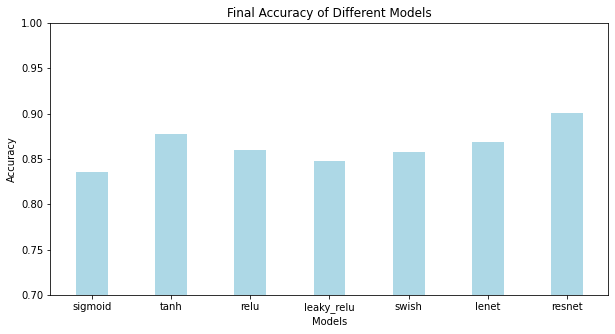

In [103]:
# 5. Evaluation
import matplotlib.pyplot as plt
import numpy as np

# sample data
models = ['sigmoid', 'tanh', 'relu', 'gelu', 'swish', 'lenet', 'resnet']
final_accuracies = []
final_accuracies.append(stats_sigmoid[3][-1])
final_accuracies.append(stats_tanh[3][-1])
final_accuracies.append(stats_relu[3][-1])
final_accuracies.append(stats_gelu_net[3][-1])
final_accuracies.append(stats_swish[3][-1])
final_accuracies.append(stats_lenet[3][-1])
final_accuracies.append(stats_resnet[3][-1])

# plot
plt.figure(figsize=(10, 5))
plt.bar(models, final_accuracies, color ='lightblue', width = 0.4)
plt.title('Final Accuracy of Different Models')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim([0.7, 1])
plt.show()

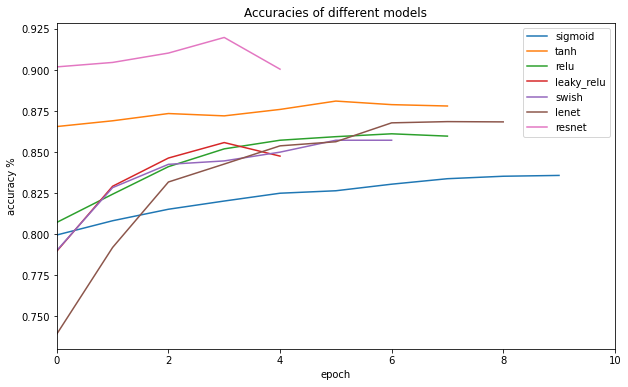

In [104]:
test_accuracies_sigmoid = stats_sigmoid[3]
test_accuracies_tanh = stats_tanh[3]
test_accuracies_relu = stats_relu[3]
test_accuracies_gelu_net = stats_gelu_net[3]
test_accuracies_swish = stats_swish[3]
test_accuracies_lenet = stats_lenet[3]
test_accuracies_resnet = stats_resnet[3]

plt.figure(figsize=(10, 6))
plt.plot(range(len(test_accuracies_sigmoid)),test_accuracies_sigmoid,label='sigmoid')
plt.plot(range(len(test_accuracies_tanh)),test_accuracies_tanh,label='tanh')
plt.plot(range(len(test_accuracies_relu)),test_accuracies_relu,label='relu')
plt.plot(range(len(test_accuracies_gelu_net)),test_accuracies_gelu_net,label='gelu')
plt.plot(range(len(test_accuracies_swish)),test_accuracies_swish,label='swish')
plt.plot(range(len(test_accuracies_lenet)),test_accuracies_lenet,label='lenet')
plt.plot(range(len(test_accuracies_resnet)),test_accuracies_resnet,label='resnet')
plt.title('Accuracies of different models')
plt.xlabel('epoch')
plt.ylabel('accuracy %')
plt.xlim([0, 10])
plt.legend()
plt.show()

## 5.2 Analysis

### 5.2.1 Compare the performance of each activation function in terms of final accuracy or error on the test set.
| Statistics | Sigmoid | tanh | ReLU | GELU | Swish | LeNet | ResNet |
|----------|----------|----------|----------|----------|----------|----------|----------|
| Test Accuracy | $83.58\%$ | $87.81\%$ | $85.97\%$ | $85.74\%$ | $85.72\%$ | $86.84\%$ | $90.05\%$ |
| Loss | $0.4582$ | $0.3362$ | $0.3934$ | $0.3936$ | $0.3941$ | $0.3612$ | 0.2953 |

### 5.2.2 Discuss the observed differences in terms of convergence speed, final performance, and any other notable characteristics.

- Convergence Speed:
    - To reach $0.85\%$ or higher accuracy on test set, **ResNet** and **MLP with tanh** show distinguished performance. **MLP with GELU**,  **ReLU**, **LeNet**, and **Swish** are the followers, while **sigmoid** seems to have slowest convergence speed.

- Final Performance
    - **ResNet** is the one reaches highest accuracy, that is $90.05\%$ within in the $10$ epochs. 
    - **tanh** and **LeNet** are the next two highest accuracies, which are $87.81\%$ and $86.84\%$.
    - **GeLU**, **Swish**, and **ReLu** have very close final accuracies, which are $85.74\%$, $85.72\%$, and $85.97\%$.
    - **Sigmoid** is again the last one, with final accuracy $83.58\%$.

- Other notable characteristics
    - Training time: 
        - For **MLP** with different activation functions, the training time is around 1 - 3 minutes, while discrepancy may be cause by early stopping and amount of calculation needed for different activation functions. 
        - As for CNN, **LeNet** takes 3m 25.2s and **ResNet** takes 15m54.1s to convergent. It is due to the differences in network architecture, as **ResNet** has much more layers than all others.
    - Hyper-parameters: 
        - It seems that the choice of hyper-parameters also has great impact on the final accuracies of models. 
        - As I changes batch-size from $64$ to $256$ in order to reduce the training time of **ResNet**, it is observed that the overall accuracies of **MLP** decreases. 

### 5.2.3 Reflect on scenarios where one activation function might be preferred over others.
- As for **MLP**
    - it seems that **tanh** is the best one when looking from the view of final accuracies, which is a little weird and inconsistent with our prediction that **ReLU** would be better. 
    - but for sure we should not consider **sigmoid** as activation function

- As for CNN
    - without considering training time, **ResNet** is the best choice. The only problem here for it would be over-fitting, so maybe techniques such as dropout can be introduced to modify. 
    - With time considered, **LeNet** is a good choice, since its training time is not considerable longer than any **MLP** methods.

### Please report the names of the last two activation functions. Tell me what's the advantage of those two functions.
- **GELU** : Gaussian Error Linear Unit
    - $GELU(x) = xP(X \leq x) = x \Phi (x) = x \cdot \frac{1}{2} [1 + erf(\frac{x}{\sqrt{2}})]$
    - $GELU(x) \approx  0.5x \left(1 + \tanh\left(\sqrt{\frac{2}{\pi}} \left(x + 0.044715x^3\right)\right)\right)$
    - GELU has been designed to approximate the cumulative distribution function of a Gaussian distribution, so its nonlinearity weights inputs by their percentile, rather than gates inputs by their sign as in **ReLU**
    - GELU is differentiable, and thus easy to calculate gradient

- **Swish**: $Swish(x) = \frac{x}{1 + e^{-x}} = x \cdot \sigma(x)$
    - While **ReLU** is the most wide-used activation functions, the biggest problem that it outputting $0$ for negative values added to back-propagation, which will cause some neurons to die, and **Swish** solves the problem.